In [2]:
import os
import csv

import random
import numpy as np

from sklearn.manifold.t_sne import TSNE
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from collections import OrderedDict

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [3]:
# f = open('../outdir.txt', 'r')
# outdir = f.read().rstrip('\n')
# f = open('../experiment_folder.txt', 'r')
# experiment_folder = f.read().rstrip('\n')
outdir = os.path.expanduser("/home/isotta/data1/stratification_ILRM/data/parkinson/cohorts/2019-1-25-9-42-11/")
experiment_folder = os.path.expanduser("/home/isotta/data1/stratification_ILRM/experiments/parkinson2019-2-11-4-42-49/")

##Read encoded vectors file and ordered medical record numbers
with open(experiment_folder + '/encoded_vect.csv') as f:
    rd = csv.reader(f)
    encoded_vect = []
    for r in rd:
        encoded_vect.append(list(map(float, r)))
        
with open(experiment_folder + '/mrns.csv') as f:
    rd = csv.reader(f)
    mrns = []
    for r in rd:
        mrns.append(r[0])
        
# ##Read encoded vectors file and ordered medical record numbers
# with open(experiment_folder + '/LSTMencoded_vect.csv') as f:
#     rd = csv.reader(f)
#     lstm_encoded_vect = []
#     for r in rd:
#         lstm_encoded_vect.append(list(map(float, r)))
        
# with open(experiment_folder + '/LSTMmrns.csv') as f:
#     rd = csv.reader(f)
#     lstm_mrns = []
#     for r in rd:
#         lstm_mrns.append(r[0])

with open(outdir + '/cohort-new_ehr.csv') as f:
    rd = csv.reader(f)
    raw_ehr = {}
    for r in rd:
        raw_ehr.setdefault(r[0], list()).extend(list(map(int, r[1::])))

##padded raw data from cohort-new_ehr.csv
raw_data = []
max_len = 0
for _, e in raw_ehr.items():
    raw_data.append(e)
    if len(e) >= max_len:
        max_len = len(e)
for idx, s in enumerate(raw_data):
    raw_data[idx] = s + [0]*(max_len-len(s))
    
##get list of first diagnosed diseases associated with mrns
with open(outdir + '/cohort-mrn_diseases.csv') as f:
    rd = csv.reader(f)
    mrn_disease = {}
    for r in rd:
        mrn_disease[r[0]] = r[1::]
        
mrn_encoded_disease = []
for m in mrns:
    mrn_encoded_disease.append(mrn_disease[m][0])

# lstm_mrn_encoded_disease = []
# for m in lstm_mrns:
#     lstm_mrn_encoded_disease.append(mrn_disease[m][0])
    
disease_dict = {}
idx = 0
for d in set(mrn_encoded_disease):
    disease_dict[d] = idx
    idx += 1

mrn_raw_disease = []
for m in raw_ehr:
    mrn_raw_disease.append(mrn_disease[m][0])

with open(outdir + '/cohort-new_vocab.csv') as f:
    rd = csv.reader(f)
    next(rd)
    new_vocab = {}
    for r in rd:
        new_vocab[r[1]] = r[0]
        
len_vocab = len(new_vocab)

In [4]:
##Hierarchical clustering function
def hclust_ehr(data, min_cl, max_cl, metric):
    best_silh = 0.0
    list_silh = []
    for n in range(min_cl,max_cl,1):
        hclust = AgglomerativeClustering(n_clusters=n, 
                                         linkage='ward', 
                                         affinity=metric)
        tmp_label = hclust.fit_predict(data).tolist()
        tmp_silh = silhouette_score(data, tmp_label)
        print(n, tmp_silh)
        list_silh.append(float(tmp_silh))
        if tmp_silh > best_silh:
            best_silh = tmp_silh
            n_clust = n
            label = tmp_label
    try:
        print("Number of clusters found:{0}, Silhouette score:{1:.3f}".format(n_clust, best_silh))
    except UnboundLocalError:
        hclust = AgglomerativeClustering(n_clusters=min_cl,
                                         linkage='complete',
                                         affinity=metric)
        n_clust = min_cl
        label = hclust.fit_predict(data).tolist()
        print("Number of clusters found:{0}, Silhouette score:{1:.3f}".format(n_clust, best_silh))
    return n_clust, label, list_silh

def svd_tfidf(data, len_vocab):
    
    count_mat = np.zeros((len(data), len_vocab))
    
    for idx, token_list in enumerate(data):
        for t in token_list:
            if t != 0: ##we start the vocabulary from 1
                count_mat[idx, t-1] += 1
                
    tfidf = TfidfTransformer()
    tfidf_mat = tfidf.fit_transform(count_mat)
    
    svd = TruncatedSVD(n_components=32)
    svd_mat = svd.fit_transform(tfidf_mat)
    
    return svd_mat

def FreqDict(tokens):
    freq_dict = {}
    for seq in tokens:
        for s in seq:
            if s not in freq_dict:
                freq_dict[s] = 1
            else:
                freq_dict[s] += 1
    return freq_dict

def freq_term(data, mrn_list, n_clusters, pred_class, n, term_list):
    encoded_groups = OrderedDict()
    encoded_seq = OrderedDict()
    for i in range(n_clusters):
        encoded_groups[i] = []
        encoded_seq[i] = []
        for j in range(len(pred_class)):
            if pred_class[j] == i:
                encoded_groups[i] += [mrn_list[j]]
                encoded_seq[i].append([rd for rd in data[str(mrn_list[j])] if rd!=0 and (str.split(new_vocab[str(rd)], "::")[0] in term_list)])
    for cl in range(n_clusters):
        print("Cluster {0} numerosity: {1}".format(cl, len(encoded_groups[cl])))
        encoded_count = FreqDict(encoded_seq[cl])
        for l in range(n):
            try:
                MFMT = max(encoded_count, key=(lambda key: encoded_count[key]))
                num_MFMT = 0
                count_pat = 0
                for ec in encoded_seq[cl]:
                    if MFMT in ec:
                        count_pat += 1
                for _, el in data.items():
                    for t in el:
                        if t == MFMT:
                            num_MFMT += 1
                print("Cluster {0} -- Relative numerosity of first most frequent term:{1} = {2:.2f} (count term {3} -- N patients {4})".format(cl,
                                                                                                new_vocab[str(MFMT)], 
                                                                                                encoded_count[MFMT]/num_MFMT, 
                                                                                                encoded_count[MFMT],
                                                                                                count_pat))
                encoded_count.pop(MFMT)
            except ValueError:
                pass
        print("\n")
        
def single_plot(data, mrn_disease, colors):
    plt.figure(figsize=(20,10))
    for cl in set(mrn_disease):
        x = [d[0] for j, d in enumerate(data) if mrn_disease[j]==cl]
        y = [d[1] for j, d in enumerate(data) if mrn_disease[j]==cl]
        cols = [c for j, c in enumerate(colors) if mrn_disease[j]==cl]
        plt.xticks([])
        plt.yticks([])
        plt.scatter(x, y, c=cols, label=cl)
    plt.legend()
    
def nonoverlap_plot(data, mrn_disease, colors):
    fig, ax = plt.subplots(len(set(mrn_disease)), 1, figsize=(20, 10*len(set(mrn_disease))))
    for idx, cl in enumerate(set(mrn_disease)):
        x = [d[0] for j, d in enumerate(data) if mrn_disease[j]==cl]
        y = [d[1] for j, d in enumerate(data) if mrn_disease[j]==cl]
        cols = [c for j, c in enumerate(colors) if mrn_disease[j]==cl]
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        ax[idx].scatter(x, y, c=cols, label=cl)
        ax[idx].legend()

In [5]:
##initialize T-SNE
tsne = TSNE(n_components=2, n_iter=5000, perplexity=40, random_state=42)

##colors
col_dict = matplotlib.colors.CSS4_COLORS
c_out = ['mintcream', 'cornsilk', 'lavenderblush', 'aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'powderblue', 'floralwhite', 'ghostwhite',
 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightgreen', 'lightgrey', 'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue',
 'lightslategray', 'lightslategrey', 'lightsteelblue', 'lightyellow', 'linen', 'palegoldenrod', 'palegreen', 'paleturquoise', 'palevioletred', 'papayawhip',
 'peachpuff', 'mistyrose', 'lemonchiffon', 'lightblue', 'seashell', 'white', 'blanchedalmond', 'oldlace', 'moccasin', 'snow']
colormap = [c for c in col_dict if c not in c_out]

In [6]:
##run the TSNE on data
encoded_tsne = tsne.fit_transform(encoded_vect).tolist()

In [7]:
##Apply hierarchical clustering to encoded data
n_clust_en, label_en, list_silh = hclust_ehr(encoded_vect, 2, 15, 'euclidean')

2 0.14078280082053984
3 0.15048680021447863
4 0.10189120612368366
5 0.12102861182821982
6 0.13255484460688458
7 0.07883778663673635
8 0.07399769732979153
9 0.07893149884662407
10 0.08874862031823595
11 0.0940476093848943
12 0.09725993808112277
13 0.0928951276479437
14 0.09500920338240458
Number of clusters found:3, Silhouette score:0.150


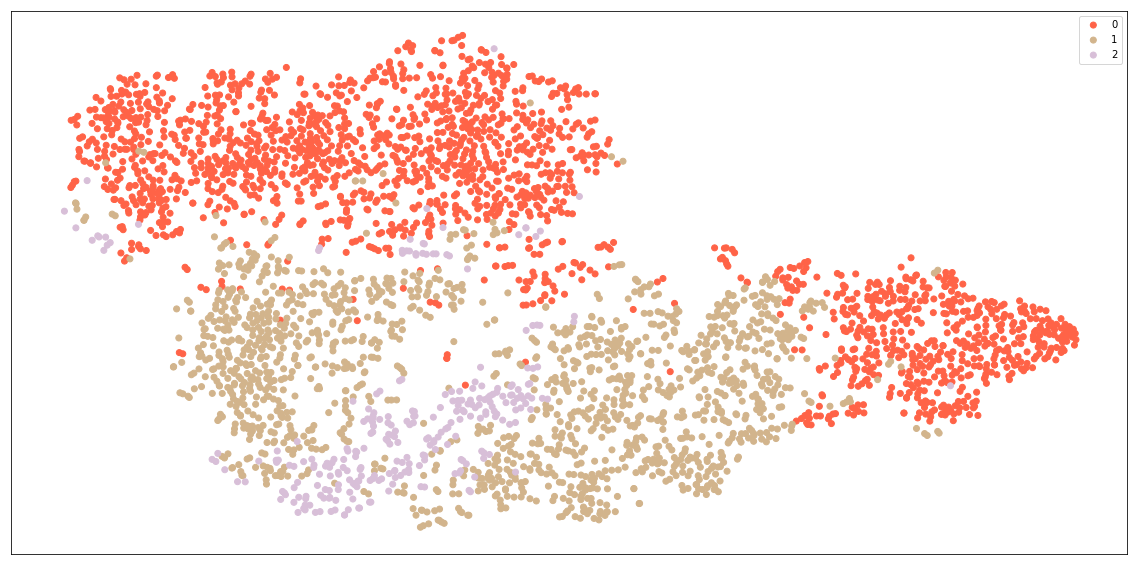

In [8]:
colors_en2 = [colormap[v] for v in label_en]
single_plot(encoded_tsne, label_en, colors_en2)

In [9]:
freq_term(raw_ehr, mrns, n_clust_en, label_en, 8, ['icd9', 'medication'])

Cluster 0 numerosity: 1955
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Paralysis agitans::332.0::C0030567 = 0.49 (count term 15582 -- N patients 1955)
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Unspecified essential hypertension::401.9::C0085580 = 0.87 (count term 9928 -- N patients 1147)
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Diabetes mellitus without mention of complication, type ii or unspecified type, not stated as uncontrolled::250.00::C0375113 = 0.92 (count term 4326 -- N patients 439)
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Constipation, unspecified::564.00::C0009806 = 0.89 (count term 3817 -- N patients 599)
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Abnormality of gait::781.2::C0575081 = 0.64 (count term 3790 -- N patients 667)
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Depressive disorder, not elsewhere classified::311::C0868892

## Count data

In [10]:
svd_mat = svd_tfidf(raw_data, len_vocab)

# with open(os.path.join(experiment_folder, "svd_mat.csv"), 'w') as f:
#     wr = csv.writer(f, delimiter=',')
#     for s in svd_mat:
#         wr.writerow(s)

In [11]:
# ##T-SNE
count_tsne = tsne.fit_transform(svd_mat)

In [12]:
n_clust_count, label_count, list_silh = hclust_ehr(svd_mat, 2, 20, 'euclidean')

2 0.11003124284036768
3 0.1089518916534472
4 0.09381401421031116
5 0.04594460456524878
6 0.027701422995265478
7 0.02648338330548186
8 0.03532980779661449
9 0.04260958426220431
10 0.04638933866696918
11 0.04483496886537011
12 0.023613545698686914
13 0.02902891410582412
14 0.037425332670259444
15 0.043292295111307486
16 0.049351459657786166
17 0.05410785999746453
18 0.0595109020857447
19 0.060910835120501196
Number of clusters found:2, Silhouette score:0.110


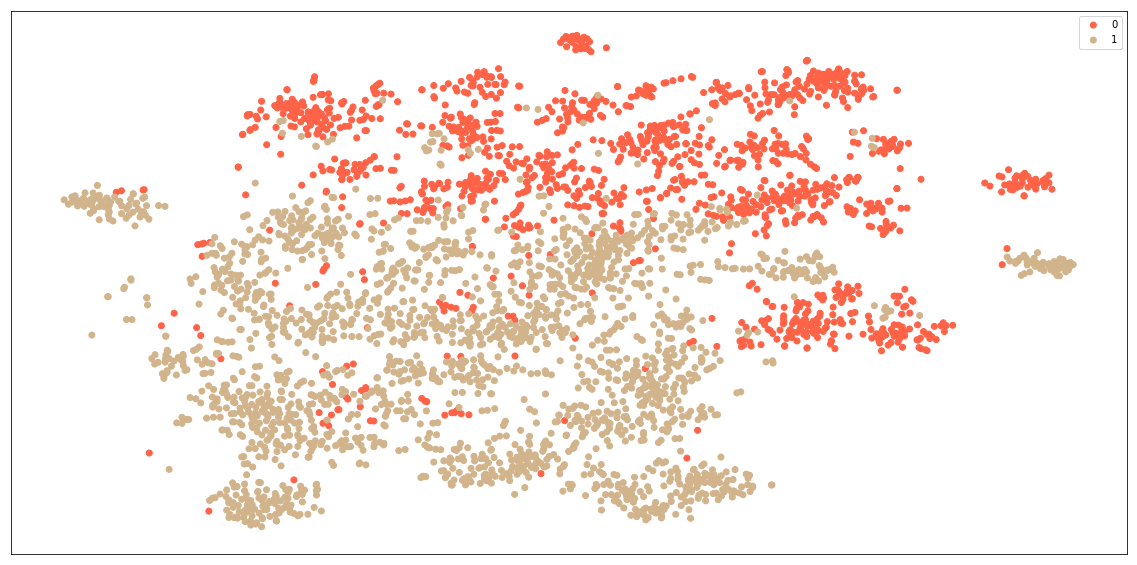

In [13]:
colors_count2 = [colormap[v] for v in label_count]
single_plot(count_tsne, label_count, colors_count2)

In [14]:
mrn_list = [m for m in raw_ehr.keys()]
freq_term(raw_ehr, mrn_list, n_clust_count, label_count, 8, ['icd9', 'medication'])

Cluster 0 numerosity: 1428
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Paralysis agitans::332.0::C0030567 = 0.38 (count term 12021 -- N patients 1428)
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Depressive disorder, not elsewhere classified::311::C0868892 = 0.23 (count term 1203 -- N patients 360)
Cluster 0 -- Relative numerosity of first most frequent term:medication::Pramipexole::746741::C0074710 = 0.64 (count term 1059 -- N patients 363)
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Anxiety state, unspecified::300.00::C0700613 = 0.42 (count term 859 -- N patients 257)
Cluster 0 -- Relative numerosity of first most frequent term:medication::Fentanyl::4337::C0015846 = 0.38 (count term 841 -- N patients 354)
Cluster 0 -- Relative numerosity of first most frequent term:medication::Clonazepam 0.5 mg::315699::C0985016 = 0.59 (count term 826 -- N patients 298)
Cluster 0 -- Relative numerosity of first most frequent term:med